In [1]:
import pandas as pd
import numpy as np
import sklearn
import datetime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# date parse format
def dateparse (time_in_secs):    
    return datetime.datetime.fromtimestamp(float(time_in_secs))

In [3]:
rating_dt = pd.read_csv('ratings.csv', 
                        #parse_dates=['timestamp'], 
                        #date_parser=dateparse
                       )
movie_dt = pd.read_csv('movies.csv')
tag_dt = pd.read_csv('tags.csv', parse_dates=['timestamp'])

In [ ]:
print(tag_dt.info())
print(movie_dt.info())
print(rating_dt.info())

### Neural Collaborative Filtering

#### Prepare data

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
# all unique user ids
user_ids = rating_dt["userId"].unique().tolist() 
num_all_user = len(user_ids)

# randomly select 20% users from rating dataset 
np.random.seed(123)
rand_userid = np.random.choice(user_ids, size = int(num_all_user * 0.1), replace=False)
sample_df = rating_dt.loc[rating_dt['userId'].isin(rand_userid)]

# userid, movieid encoding by indices
user_ids = sample_df['userId'].unique()
num_users = len(user_ids)
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded2user = {i: x for i, x in enumerate(user_ids)}
sample_df['user_encoded'] = sample_df['userId'].map(user2user_encoded)

movie_ids = sample_df['movieId'].unique()
num_movies = len(movie_ids)
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
sample_df['movie_encoded'] = sample_df['movieId'].map(movie2movie_encoded)

# train-test split
train, test = train_test_split(sample_df, test_size = 0.2, random_state=123)

num_train_user = len(np.unique(train['user_encoded']))
num_train_movie = len(np.unique(train['movie_encoded']))

print(f'total movie: {num_movies}', 
      f'\nmovie in train: {num_train_movie}', 
      f'\nmovie not in train: {num_movies - num_train_movie} ({1 - num_train_movie / num_movies :.2f})', 
      f'\n\ntotal user: {num_users}', 
      f'\nuser in train: {num_train_user}', 
      f'\nuser not in train: {num_users - num_train_user} ({1 - num_train_user / num_users :.2f})'
     )

C:\Users\fucce\AppData\Local\Temp/ipykernel_12356/2584553989.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['user_encoded'] = sample_df['userId'].map(user2user_encoded)
C:\Users\fucce\AppData\Local\Temp/ipykernel_12356/2584553989.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['movie_encoded'] = sample_df['movieId'].map(movie2movie_encoded)


total movie: 30496 
movie in train: 28206 
movie not in train: 2290 (0.08) 

total user: 16254 
user in train: 16254 
user not in train: 0 (0.00)


#### Embedding and model

In [6]:
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, Dropout, Dense, BatchNormalization, concatenate, dot
from keras.optimizers import Adam
from keras.utils import plot_model, model_to_dot
from keras.constraints import non_neg
from IPython.display import SVG
from sklearn.metrics import mean_squared_error
import os

In [7]:
# input: an integer as embedding layer size, a float as drop out probability
# output: a keras NCF model with pre-constructed layers
def NCF_model(embed_size = 10, drop_out_prob = 0.2): 
    # define spaceholder of embedding inputs
    movie_input = Input(shape=[1],name='movie-input')
    user_input = Input(shape=[1], name='user-input')

    # MLP embeddings for both user and movie
    movie_embedding_mlp = Embedding(num_movies, embed_size, 
                                    name='movie-embedding-mlp')(movie_input)
    movie_vec_mlp = Flatten(name='flatten-movie-mlp')(movie_embedding_mlp)
    movie_vec_mlp = Flatten(name='flatten-movie-mlp')(movie_embedding_mlp)

    user_embedding_mlp = Embedding(num_users, embed_size, 
                                   name='user-embedding-mlp')(user_input)
    user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

    # MF embeddings for both user and movie
    movie_embedding_mf = Embedding(num_movies, embed_size, 
                                   name='movie-embedding-mf')(movie_input)
    movie_vec_mf = Flatten(name='flatten-movie-mf')(movie_embedding_mf)

    user_embedding_mf = Embedding(num_users, embed_size, 
                                  name='user-embedding-mf')(user_input)
    user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

    # MLP layers
    concat = concatenate([movie_vec_mlp, user_vec_mlp], axis=-1, name='concat')
    concat_dropout = Dropout(drop_out_prob)(concat)

    fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
    fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
    fc_1_dropout = Dropout(drop_out_prob)(fc_1_bn)

    fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
    fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
    fc_2_dropout = Dropout(drop_out_prob)(fc_2_bn)

    # Prediction from both layers
    pred_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
    pred_mf = dot([movie_vec_mf, user_vec_mf], axes=1, normalize=False)

    combine_mlp_mf = concatenate([pred_mf, pred_mlp], axis=-1, name='pred_mf')

    # Final prediction
    result = Dense(1, name='result', activation='relu')(combine_mlp_mf)

    model = Model([user_input, movie_input], result)
    model.compile(optimizer=Adam(lr=0.01), loss='mean_squared_error')

    return model

In [8]:
model = NCF_model()



c:\Users\fucce\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 movie-input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 user-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 movie-embedding-mlp (Embedding  (None, 1, 10)       304960      ['movie-input[0][0]']            
 )                                                                                                
                                                                                                  
 user-embedding-mlp (Embedding)  (None, 1, 10)       162540      ['user-input[0][0]']       

Epoch 1/5
61259/61259 [==============================] - 1082s 18ms/step - loss: 0.8401
Epoch 2/5
61259/61259 [==============================] - 988s 16ms/step - loss: 0.7781
Epoch 3/5
61259/61259 [==============================] - 933s 15ms/step - loss: 0.7619
Epoch 4/5
61259/61259 [==============================] - 1078s 18ms/step - loss: 0.7516
Epoch 5/5
61259/61259 [==============================] - 1185s 19ms/step - loss: 0.7442


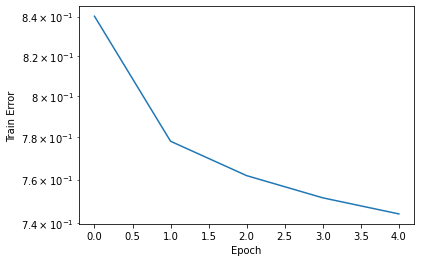

In [13]:
# train NCF model on training data, embedding size 20, dropout rate as default
model = NCF_model(embed_size=20)
history = model.fit([train['user_encoded'], train['movie_encoded']], train['rating'], epochs=5)

pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

In [10]:
#load model from file
model =  tf.keras.models.load_model('rec_model.h5')

In [11]:
# rmse on testing set 
y_hat = np.round(model.predict([test['user_encoded'], test['movie_encoded']]), decimals=2)
y_true = test['rating']
print(f'testing rms: {mean_squared_error(y_true, y_hat)}')

15315/15315 [==============================] - 14s 888us/step
testing rms: 0.7927284574436628


#### Performance on inactive / active users

#### Cross-validation on validation set

In [17]:
from sklearn.model_selection import KFold

valid_df_size = 100000
valid_df = train.sample(n = int(valid_df_size), replace=False, random_state=123)

embedding_layers = [5, 10, 15, 20, 25, 30]

In [18]:

def NCF_cross_validation(cv_df, eb_layers, drop_prob = 0.2, epoch=3, n_split=3):
    cv_result = []

    for el in eb_layers:      
        temp_loss = []
        itr_idx = 0
        
        for train_idx, test_idx in KFold(n_split).split(cv_df):          
            cv_train_x = cv_df.iloc[train_idx][['user_encoded', 'movie_encoded']]
            cv_test_x = cv_df.iloc[test_idx][['user_encoded', 'movie_encoded']]
            cv_train_y = cv_df.iloc[train_idx]['rating']
            cv_test_y = cv_df.iloc[test_idx]['rating']

            model_cv = NCF_model()
            model_cv.fit([cv_train_x['user_encoded'], cv_train_x['movie_encoded']], cv_train_y, epochs=epoch)

            curr_loss = model_cv.evaluate([cv_df['user_encoded'], cv_df['movie_encoded']], cv_df['rating'])
            temp_loss.append(curr_loss)         
            itr_idx += 1
            
        cv_result.append(sum(temp_loss) / n_split)
            
    return cv_result

In [19]:
cv_result = NCF_cross_validation(valid_df, embedding_layers)

Epoch 1/3


c:\Users\fucce\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 16s 7ms/step - loss: 1.1923
Epoch 2/3
2084/2084 [==============================] - 14s 7ms/step - loss: 0.8832
Epoch 3/3
3125/3125 [==============================] - 3s 1ms/step - loss: 0.5147
Epoch 1/3


c:\Users\fucce\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 15s 7ms/step - loss: 1.1943
Epoch 2/3
2084/2084 [==============================] - 14s 7ms/step - loss: 0.8823
Epoch 3/3
3125/3125 [==============================] - 3s 940us/step - loss: 0.5173
Epoch 1/3


c:\Users\fucce\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 15s 7ms/step - loss: 1.1953
Epoch 2/3
2084/2084 [==============================] - 14s 7ms/step - loss: 0.8819
Epoch 3/3
3125/3125 [==============================] - 3s 891us/step - loss: 0.5391
Epoch 1/3


c:\Users\fucce\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 15s 7ms/step - loss: 1.1820
Epoch 2/3
2084/2084 [==============================] - 14s 7ms/step - loss: 0.8542
Epoch 3/3
3125/3125 [==============================] - 3s 882us/step - loss: 0.5427
Epoch 1/3


c:\Users\fucce\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 15s 7ms/step - loss: 1.1859
Epoch 2/3
2084/2084 [==============================] - 15s 7ms/step - loss: 0.8178
Epoch 3/3
3125/3125 [==============================] - 3s 888us/step - loss: 0.5013
Epoch 1/3


c:\Users\fucce\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 16s 7ms/step - loss: 1.1809
Epoch 2/3
2084/2084 [==============================] - 15s 7ms/step - loss: 0.8990
Epoch 3/3
3125/3125 [==============================] - 3s 966us/step - loss: 0.5537
Epoch 1/3


c:\Users\fucce\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 16s 7ms/step - loss: 1.1770
Epoch 2/3
2084/2084 [==============================] - 16s 8ms/step - loss: 0.8841
Epoch 3/3
3125/3125 [==============================] - 4s 1ms/step - loss: 0.5374
Epoch 1/3


c:\Users\fucce\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 19s 8ms/step - loss: 1.2146
Epoch 2/3
2084/2084 [==============================] - 16s 8ms/step - loss: 0.8281
Epoch 3/3
3125/3125 [==============================] - 3s 1ms/step - loss: 0.4978
Epoch 1/3


c:\Users\fucce\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 17s 8ms/step - loss: 1.2067
Epoch 2/3
2084/2084 [==============================] - 16s 8ms/step - loss: 0.8917
Epoch 3/3
3125/3125 [==============================] - 3s 1ms/step - loss: 0.5099
Epoch 1/3


c:\Users\fucce\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 17s 8ms/step - loss: 1.2205
Epoch 2/3
2084/2084 [==============================] - 16s 8ms/step - loss: 0.8289
Epoch 3/3
3125/3125 [==============================] - 3s 997us/step - loss: 0.4977
Epoch 1/3


c:\Users\fucce\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 17s 8ms/step - loss: 1.1816
Epoch 2/3
2084/2084 [==============================] - 15s 7ms/step - loss: 0.8628
Epoch 3/3
3125/3125 [==============================] - 3s 1ms/step - loss: 0.6860
Epoch 1/3


c:\Users\fucce\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 17s 7ms/step - loss: 1.1921
Epoch 2/3
2084/2084 [==============================] - 15s 7ms/step - loss: 0.8725
Epoch 3/3
3125/3125 [==============================] - 3s 1ms/step - loss: 0.5752
Epoch 1/3


c:\Users\fucce\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 15s 7ms/step - loss: 1.1664
Epoch 2/3
2084/2084 [==============================] - 13s 6ms/step - loss: 0.8749
Epoch 3/3
3125/3125 [==============================] - 3s 757us/step - loss: 0.5211
Epoch 1/3


c:\Users\fucce\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 13s 6ms/step - loss: 1.1933
Epoch 2/3
2084/2084 [==============================] - 13s 6ms/step - loss: 0.8627
Epoch 3/3
3125/3125 [==============================] - 3s 946us/step - loss: 0.5862
Epoch 1/3


c:\Users\fucce\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 14s 6ms/step - loss: 1.1879
Epoch 2/3
2084/2084 [==============================] - 12s 6ms/step - loss: 0.9049
Epoch 3/3
3125/3125 [==============================] - 3s 772us/step - loss: 0.5990
Epoch 1/3


c:\Users\fucce\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 14s 6ms/step - loss: 1.1791
Epoch 2/3
2084/2084 [==============================] - 13s 6ms/step - loss: 0.8716
Epoch 3/3
3125/3125 [==============================] - 3s 921us/step - loss: 0.5199
Epoch 1/3


c:\Users\fucce\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 18s 8ms/step - loss: 1.1864
Epoch 2/3
2084/2084 [==============================] - 15s 7ms/step - loss: 0.8749
Epoch 3/3
3125/3125 [==============================] - 3s 992us/step - loss: 0.6678
Epoch 1/3


c:\Users\fucce\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 17s 8ms/step - loss: 1.1701
Epoch 2/3
2084/2084 [==============================] - 16s 8ms/step - loss: 0.8811
Epoch 3/3
3125/3125 [==============================] - 3s 963us/step - loss: 0.5081


[Text(0.5, 0, 'Embedding Dim'),
 Text(0, 0.5, 'CV rmse'),
 Text(0.5, 1.0, '3-Fold CV')]

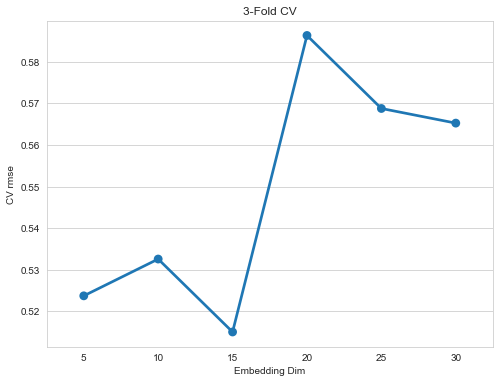

In [20]:
cv_result_df = pd.DataFrame({'cv_rmse': cv_result}, index = embedding_layers)

fig, ax = plt.subplots(figsize=(8, 6))
sns.set_style('whitegrid')
sns.pointplot(x=cv_result_df.index, y=cv_result_df.cv_rmse, ax=ax)
ax.set(xlabel='Embedding Dim', ylabel='CV rmse', title='3-Fold CV')